# LIBRARIES


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import pickle
import numpy as np
from imblearn.over_sampling import SMOTE
import compress_fasttext

# INISIASI DATASET


In [23]:
# import
SENTIMENT_DATASET_FILE_NAME = "sentiment.csv"
SENTIMENT_DATASET_FILE_PATH = f"outputs/{SENTIMENT_DATASET_FILE_NAME}"
DATA_FRAME_SENTIMENT_DATASET = pd.read_csv(SENTIMENT_DATASET_FILE_PATH)
DATA_FRAME_SENTIMENT_DATASET_LENGTH = len(DATA_FRAME_SENTIMENT_DATASET)
print(f"labelled dataset: {DATA_FRAME_SENTIMENT_DATASET_LENGTH} tweets")
display(DATA_FRAME_SENTIMENT_DATASET.tail(1))
sentiment = DATA_FRAME_SENTIMENT_DATASET

labelled dataset: 3239 tweets


,user_id,username,user_display_name,tweet_id,full_text,created_at,cleaned_text,after_slang_text,underscore_negation_text,swap_negation_text,final_negation_text,is_different,after_stopwords_text,after_stemming_text,preprocessed_text,compound_score,sentiment_label
3238,1689531424054104064,arnold_sptr33,Arnold Saputra,1831181867472867445,@meraaahputiiih Pemindahan ibu kota mengilhami...,Wed Sep 04 04:05:53 +0000 2024,pemindahan ibu kota mengilhami kita untuk menj...,pemindahan ibu kota mengilhami kita untuk menj...,pemindahan ibu kota mengilhami kita untuk menj...,pemindahan ibu kota mengilhami kita untuk menj...,pemindahan ibu kota mengilhami kita untuk menj...,False,pemindahan kota mengilhami menjaga keanekaraga...,pindah kota ilham jaga keanekaragaman hayati,pindah kota ilham jaga keanekaragaman hayati,-0.2626,negatif


# fastText


In [24]:
ft_model = compress_fasttext.models.CompressedFastTextKeyedVectors.load("models/fastText/fasttext-id-mini")

def get_sentence_vector(text):
    words = text.split()
    word_vectors = [ft_model[word] for word in words if word in ft_model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros((300,))
    
sentiment["ft_embed"] = sentiment["preprocessed_text"].apply(get_sentence_vector)

In [25]:
X = np.stack(sentiment["ft_embed"].values)
y = sentiment["sentiment_label"].values

# DATA SPLIT (80% TRAIN, 20% TEST)


In [26]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2,random_state=21)

# SMOTE


In [27]:
smote = SMOTE(random_state=21)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

# KNN InSet


| k = 1 |
| accuracy: 0.73 |
| precision: 0.7963475678303407 |
| recall: 0.7330246913580247 |
| f1: 0.7456573841130912 |


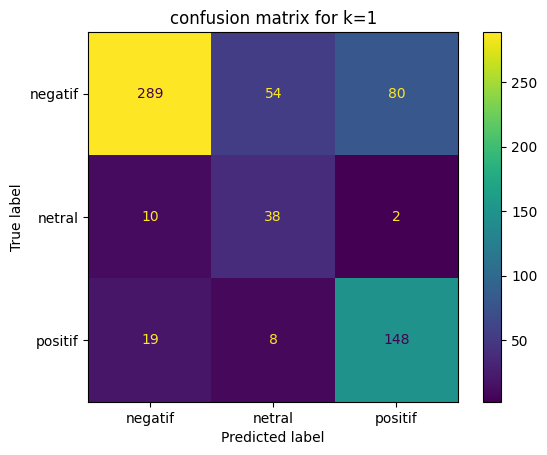

| k = 3 |
| accuracy: 0.70 |
| precision: 0.7858009621606572 |
| recall: 0.6990740740740741 |
| f1: 0.714368577524613 |


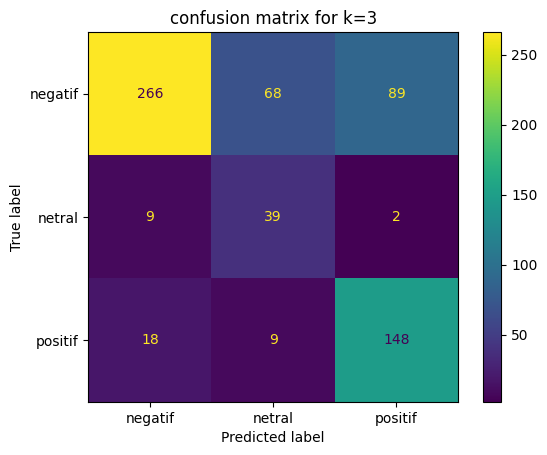

| k = 5 |
| accuracy: 0.67 |
| precision: 0.7868096106472504 |
| recall: 0.6697530864197531 |
| f1: 0.6883285856073205 |


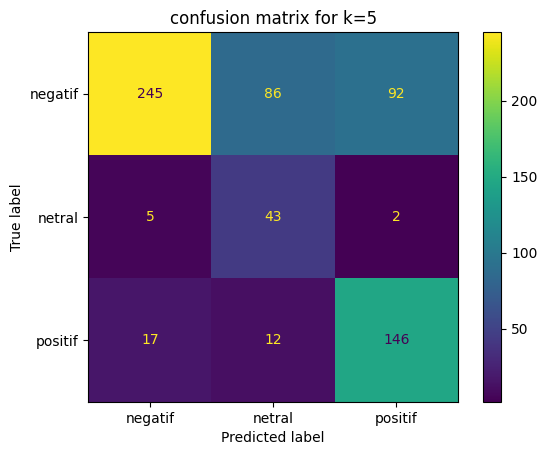

| k = 7 |
| accuracy: 0.65 |
| precision: 0.7890498008098431 |
| recall: 0.6466049382716049 |
| f1: 0.6643164611667149 |


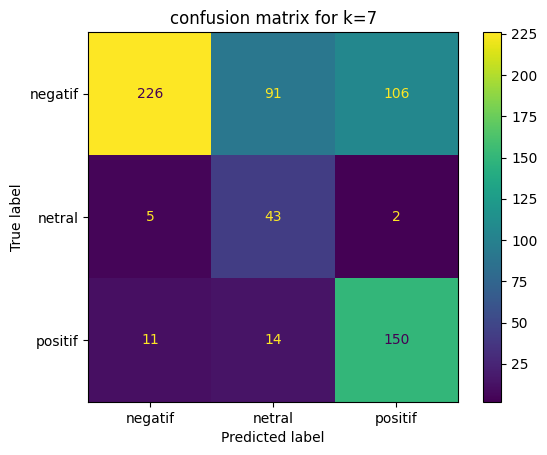

In [28]:
def train_evaluate_knn(k, X_train, Y_train, X_test, Y_test):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    print(f"| k = {k} |")
    print(f"| accuracy: {accuracy:.2f} |")
    print(f"| precision: {precision} |")
    print(f"| recall: {recall} |")
    print(f"| f1: {f1} |")
    
    cm = confusion_matrix(Y_test, y_pred, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
    disp.plot()
    plt.title(f"confusion matrix for k={k}")
    plt.show()
    
    return knn

knn1 = train_evaluate_knn(1, X_train_smote, Y_train_smote, X_test, Y_test)
knn3 = train_evaluate_knn(3, X_train_smote, Y_train_smote, X_test, Y_test)
knn5 = train_evaluate_knn(5, X_train_smote, Y_train_smote, X_test, Y_test)
knn7 = train_evaluate_knn(7, X_train_smote, Y_train_smote, X_test, Y_test)

# DUMP KNN MODEL


In [31]:
def save_model(model, filename):
    with open(filename, 'wb') as model_file:
            pickle.dump(model, model_file)

# save_model(knn1, 'models/8020/knn1_8020_model.pkl')
# save_model(knn3, 'models/8020/knn3_8020_model.pkl')
# save_model(knn5, 'models/8020/knn5_8020_model.pkl')
# save_model(knn7, 'models/8020/knn7_8020_model.pkl')